In [413]:
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque, OrderedDict
from copy import deepcopy
import numpy as np
import gymnasium as gym
from gymnasium import spaces

NC = 10
NT = 7
NL = 2
TSCOPE = 720 #hours
NCUTS = 5
MAXCARGO = 250

In [261]:
def randomComp(nCrudes):
    c = np.random.random(nCrudes)
    return c/np.sum(c)

In [262]:
def randomSched(nCrudes, cargoSizes, tScope):
    d = dict()
    cargoVols = np.random.permutation(cargoSizes)
    cargoCrudes = np.random.randint(0, 10, cargoVols.shape[0])
    cargoTimes = np.sort(np.random.randint(0, tScope, cargoVols.shape[0]))
    for i, t in enumerate(cargoTimes):
        comp = np.zeros(10)
        comp[cargoCrudes[i]] = 1
        d[t] = crudeParcel(cargoVols[i], comp)
    return d
    

In [263]:
def randomAssay(nCrudes, nCuts):
    a = []
    for i in range(nCrudes):
        a.append(randomComp(nCuts))
    return np.transpose(np.array(a))

In [264]:
assay = randomAssay(NC, NCUTS)
comp = randomComp(NC)

In [265]:
def flatten_dict(dd, separator='_', prefix=''):
    '''https://stackoverflow.com/questions/6027558/flatten-nested-dictionaries-compressing-keys'''
    return { prefix + separator + k if prefix else k : v
             for kk, vv in dd.items()
             for k, v in flatten_dict(vv, separator, kk).items()
             } if isinstance(dd, dict) else { prefix : dd }

In [414]:
class crudeTanksEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(crudeTanksEnv, self).__init__()

        self.action_space = spaces.Dict({
            'farmTanks': spaces.MultiDiscrete([13, 6]),
            'unitFeed': spaces.Box(low=0, high=1.0, shape=(), dtype=np.float64)
        })

        self.observation_space = spaces.Dict({
            'tkVols': spaces.Box(low=0, high=MAXCARGO, shape=(NT,), dtype=np.float64), 
            'tkVolUtils': spaces.Box(low=0, high=MAXCARGO, shape=(NT,), dtype=np.float64), 
            'tkVolEmpties': spaces.Box(low=-50, high=MAXCARGO, shape=(NT,), dtype=np.float64), 
            'tkComps': spaces.Box(low=0, high=1.0, shape=(NT, NC), dtype=np.float64), 
            'tkCuts': spaces.Box(low=0, high=1.0, shape=(NT, NCUTS), dtype=np.float64), 
            'linVols': spaces.Box(low=0, high=20.0, shape=(NL,), dtype=np.float64), 
            'linComps': spaces.Box(low=0, high=1.0, shape=(NL, NC), dtype=np.float64),
            'linCuts': spaces.Box(low=0, high=1.0, shape=(NL, NCUTS), dtype=np.float64),
            'unitProds': spaces.Box(low=0, high=10.0, shape=(NCUTS,), dtype=np.float64)

        })
        
        self.S = siteReset({})
        return
  
    def step(self, action):
    # Execute one time step within the environment
        return siteStep(action, self.S)

    def reset(self, seed=None, **kwargs):
    # Reset the state of the environment to an initial state
        super().reset(seed=seed)
        self.S, obs = siteReset(kwargs)
        return obs, {'sched': deepcopy(self.S.cargo.sched), 
                     'assay': deepcopy(self.S.unit.assay), 
                     'unitVolCutMax': deepcopy(self.S.unit.volCutMax)}
  
    def render(self, mode='human', close=False):
    # Render the environment to the screen
        siteRender(self.S)
        return

In [446]:
#del gym.envs.registry['crudeTanksEnv']
gym.envs.registration.register(
    'crudeTanksEnv-v0',
    crudeTanksEnv,
    reward_threshold=500,
    max_episode_steps=720
)

C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\envs\registration.py:498: UserWarning: WARN: Overriding environment crudeTanksEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [452]:
env = gym.envs.make('crudeTanksEnv-v0')
env.spec
#env = crudeTanksEnv()

EnvSpec(id='crudeTanksEnv-v0', entry_point=<class '__main__.crudeTanksEnv'>, reward_threshold=500, nondeterministic=False, max_episode_steps=720, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='crudeTanksEnv', version=0)

C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


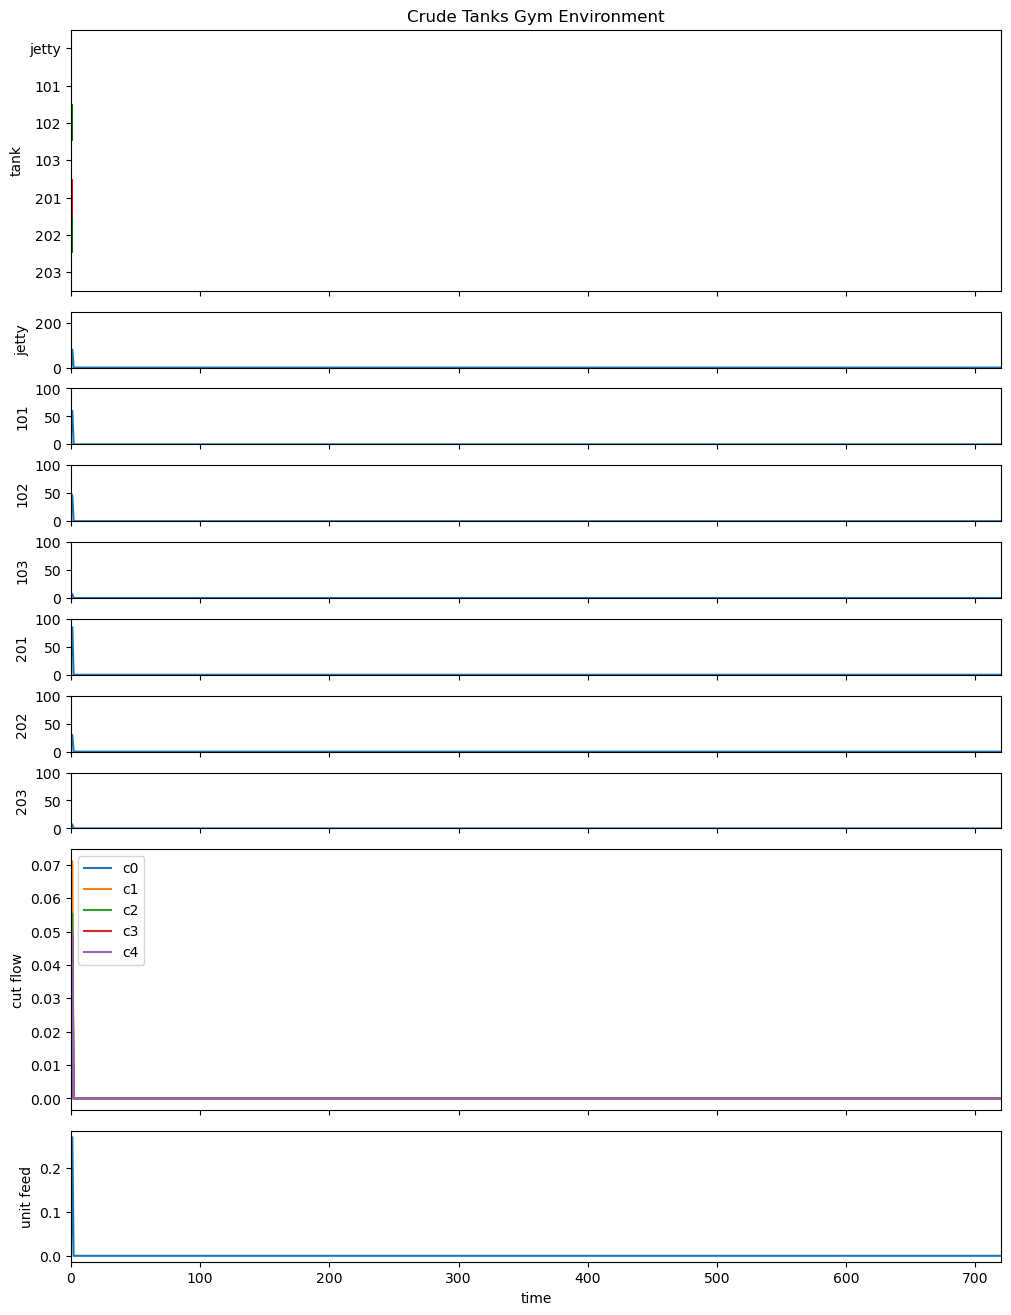

In [459]:
state0, fixDict = env.reset()
state = env.step(env.action_space.sample())
env.render()

In [352]:
#env.observation_space.sample()
env.reset(seed=200560)[0]

OrderedDict([('linComps',
              array([[0.1386933 , 0.10560794, 0.09876278, 0.16004022, 0.04573921,
                      0.07707512, 0.04490436, 0.10166553, 0.06924299, 0.15826854],
                     [0.11512542, 0.11154218, 0.08195822, 0.20004919, 0.13284202,
                      0.14051538, 0.11905236, 0.06966185, 0.02651973, 0.00273363]])),
             ('linCuts',
              array([[0.17196127, 0.17867706, 0.19089501, 0.14197035, 0.31649631],
                     [0.16380873, 0.22351511, 0.17723127, 0.14934035, 0.28610454]])),
             ('linVols', array([5. , 7.5])),
             ('tkComps',
              array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                      0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
                      0.00000000e+00, 0.00000000e+00],
                     [8.05214515e-02, 5.93304320e-02, 8.49007532e-02, 4.39497466e-02,
                      2.38948105e-04, 2.51924577e-01, 9.20873348

In [353]:
env.observation_space.sample() in env.observation_space, env.reset()[0] in env.observation_space

(True, True)

In [332]:
from gymnasium.utils.env_checker import check_env
check_env(env)

In [272]:
class crudeParcel():
    def __init__(self, vol: float, comp: np.array):
        self.vol = vol
        self.comp = comp
    
    def toDict(self):
        return {'vol': self.vol, 'comp': self.comp}
    
    def __str__(self):
        return 'vol: {:6.2f} comp: {}'.format(self.vol, np.array_str(self.comp, precision=2, suppress_small=True))
    
    def __repr__(self):
        return 'vol: {:6.2f} comp: {}'.format(self.vol, np.array_str(self.comp, precision=2, suppress_small=True))

In [273]:
class crudeTank(crudeParcel):
    def __init__(self, name: str, vol: float, comp: np.array, volMin: float, volMax: float):
        super().__init__(vol, comp)
        self.name = name
        self.volMin = volMin
        self.volMax = volMax
        assert self.vol >= self.volMin, '{} Initial volumen below min'.format(self.name)  
        assert self.vol <= self.volMax, '{} Initial volumen above max'.format(self.name)
        self.actVol()
        return
    
    def actVol(self, v=0):
        self.vol += v
        self.volUtil = self.vol - self.volMin
        self.volEmpty = self.volMax - self.vol
        return
    
    def getParcel(self, v):
        assert v > 0, '{} Volume drawn must be positive'.format(self.name)
        v = min(v, self.volUtil)
        self.actVol(-v)
        return crudeParcel(v, self.comp)
    
    def putParcel(self, cP):
        self.comp = (self.vol * self.comp + cP.vol * cP.comp)/(self.vol+cP.vol)
        self.actVol(cP.vol)
        if self.vol > self.volMax:
            print('\nTank {} vol above max after putParcel\n'.format(self.name))
        return
        
    def toDict(self):
        return {'volUtil': self.volUtil, 'volMin': self.volMin,'volMax': self.volMax, 
                'cP': super().toDict()}        
    
    @classmethod
    def fromCrudeParcel(cls, name, cP: crudeParcel, volMin, volMax):
        return cls(name, cP.vol, cP.comp, volMin, volMax)
    
    def __str__(self):
        return 'Tank {:6s} {}'.format(self.name, super().__str__())    
    

In [415]:
class crudeCargo(crudeTank):
    def __init__(self, name: str, sched: dict):
        self.sched = sched
        if 0 in sched.keys():
            super().__init__(name, self.sched[0].vol, self.sched[0].comp, 0, MAXCARGO)
            del self.sched[0]
        else:
            super().__init__(name, 0, randomComp(NC), 0, MAXCARGO)
    
    def act(self, t):
        if len(self.sched) > 0:
            ts = min(self.sched.keys())
            if self.vol < np.finfo(np.float32).eps and t <= ts:
                self.vol = self.sched[ts].vol
                self.comp = self.sched[ts].comp
                self.actVol()
                del self.sched[ts]
        return

In [275]:
class line():
    def __init__(self, name: str, lineVol: float, lineCrudeParcels: list):
        assert lineVol == sum([cP.vol for cP in lineCrudeParcels]), "line Crude Parcels don't add up to line vol"
        self.name = name
        self.lineVol = lineVol
        self.lineCrudeParcels = deque(lineCrudeParcels)
        return
    
    def move(self, cP):
        moveList = []
        if np.array_equal(cP.comp, self.lineCrudeParcels[-1].comp):
            self.lineCrudeParcels[-1].vol += cP.vol
        else:
            self.lineCrudeParcels.append(cP)
        v = cP.vol
        while v > 0:
            if self.lineCrudeParcels[0].vol > v:
                moveList.append(crudeParcel(v, self.lineCrudeParcels[0].comp))
                self.lineCrudeParcels[0].vol -= v
                v = 0
            else:
                moveList.append(self.lineCrudeParcels[0])
                v -= self.lineCrudeParcels.popleft().vol
        return moveList
                
    def toDict(self):
        return {'lineVol': self.lineVol, 'cP': self.lineCrudeParcels[0].toDict()}        
    
    def __str__(self):
        txt = ''
        for cP in self.lineCrudeParcels:
            txt += 'Line {:5s} {}\n'.format(self.name, cP.__str__())
        return txt[:-1]

In [276]:
class crudeTanks():
    def __init__(self):
        self.ts = dict()
        return
    
    def add(self, cT):
        self.ts[cT.name] = cT
        return
    
    def get(self, name):
        return self.ts[name]
    
    def toDict(self):
        d = dict()
        for k in self.ts.keys():
            d[k] = self.ts[k].toDict()
        return d
    
    def __str__(self):
        txt = ''
        for k in self.ts.keys():
            txt += '{}\n'.format(self.ts[k].__str__())
        return txt[:-1]

    def __repr__(self):
        return self.__str__()

In [277]:
class lines():
    def __init__(self):
        self.ls = dict()
        return
    
    def add(self, l):
        self.ls[l.name] = l
        return
    
    def get(self, name):
        return self.ls[name]
    
    def toDict(self):
        d = dict()
        for k in self.ls.keys():
            d[k] = self.ls[k].toDict()
        return d

    def __str__(self):
        txt = ''
        for k in self.ls.keys():
            txt += '{}\n'.format(self.ls[k].__str__())
        return txt[:-1]
    
    def __repr__(self):
        return self.__str__()

In [278]:
class pump():
    def __init__(self, name, volMax):
        self.name = name
        self.volMax = volMax
        return
    
    def flow(self, v=None):
        if v is None:
            return self.volMax
        else:
            return min(v, self.volMax)

    def toDict(self):
        return {'volMax': self.volMax}        
    
    def __str__(self):
        return 'Pump {:5s} {:4.2f}'.format(self.name, self.volMax)

In [279]:
class pumps():
    def __init__(self):
        self.ps = dict()
    
    def add(self, p):
        self.ps[p.name] = p
        return
    
    def get(self, name):
        return self.ps[name]
    
    def toDict(self):
        d = dict()
        for k in self.ps.keys():
            d[k] = self.ps[k].toDict()
        return d

    def __str__(self):
        txt = ''
        for k in self.ps.keys():
            txt += '{}\n'.format(self.ps[k].__str__())
        return txt[:-1]
    
    def __repr__(self):
        return self.__str__()

In [280]:
class crudeUnit():
    def __init__(self, name: str, assay: np.array, volCutMax: np.array):
        self.name = name
        self.assay = assay
        self.volCutMax = volCutMax
        self.prod = np.zeros(assay.shape[0])
        return
    
    def distil(self, cP):
        yields = np.matmul(self.assay, cP.comp)
        v = np.min(np.append(self.volCutMax/yields, [cP.vol]))
        self.prod = v * yields
        return v

    def toDict(self):
        return {'assay': self.assay, 'volCutMax': self.volCutMax,'prod': self.prod}
    
    def __str__(self):
        return 'Prod: {}'.format(np.array_str(self.prod, precision=2, suppress_small=True))
    
    def __repr__(self):
        return self.__str__()

In [457]:
class site():
    def __init__(self):
        self.tanks = crudeTanks()
        self.lines = lines()
        self.pumps = pumps()
        self.cargo = None
        self.unit = None
        self.t = 0
        self.reward = 0
        self.lastAction = np.zeros(2, dtype=int)
        self.movesLog = OrderedDict()
        self.prodsLog = OrderedDict()
        self.tkVolsLog = OrderedDict()
        return
    
    def addTank(self, cT):
        self.tanks.add(cT)
        return
    
    def addCargo(self, cT):
        self.tanks.add(cT)
        self.cargo = cT
        return

    def addLine(self, lin):
        self.lines.add(lin)
        return
    
    def addPump(self, p):
        self.pumps.add(p)
        return
    
    def addUnit(self, u):
        self.unit = u
        return

    def tank(self, name):
        return self.tanks.get(name)
    
    def line(self, name):
        return self.lines.get(name)

    def pump(self, name):
        return self.pumps.get(name)

    def move(self, tin, tout, lin, p, v=None):
        v = self.pump(p).flow(v)
        v = min(v, self.tank(tin).volUtil)
        v = min(v, self.tank(tout).volEmpty)
        if v > 0:
            moveList = self.line(lin).move(self.tank(tin).getParcel(v))
            for cP in moveList:
                self.tank(tout).putParcel(cP)
            self.movesLog[self.t][tin] = -1
            self.movesLog[self.t][tout] = 1
        return

    def move_(self, tin, tout, v):
        v = min(v, self.tank(tin).volUtil)
        v = min(v, self.tank(tout).volEmpty)
        self.tank(tout).putParcel(self.tank(tin).getParcel(v))
        return
    
    def feedUnit(self, tk, p, per=None):
        if per is not None:
            v = per*self.pump(p).flow()
        v = self.pump(p).flow(v)
        v = min(v, self.tank(tk).volUtil)
        if v > 0:
            v = self.unit.distil(crudeParcel(v, self.tank(tk).comp))
            _ = self.tank(tk).getParcel(v)
            self.reward += v
            self.movesLog[self.t][tk] = -1
            self.prodsLog[self.t] = self.unit.prod
        return

    def newStep(self):
        self.t += 1
        self.cargo.act(self.t)
        self.reward = 0.0
        self.movesLog[self.t] = {}
        return
    
    def toDict(self):
        d = dict()
        d['tanks'] = self.tanks.toDict()
        d['lines'] = self.lines.toDict()
        d['pumps'] = self.pumps.toDict()
        d['unit'] = self.unit.toDict()
        return d
    
    def toObs(self):
        d = OrderedDict({'linComps': [], 'linCuts': [], 'linVols': [], 'tkComps': [], 'tkCuts': [], 
                         'tkVolEmpties': [], 'tkVolUtils': [], 'tkVols': [], 'unitProds': 0})
        for k in self.tanks.ts.keys():
            d['tkVols'].append(self.tank(k).vol)
            d['tkVolUtils'].append(self.tank(k).volUtil)
            d['tkVolEmpties'].append(self.tank(k).volEmpty)
            d['tkComps'].append(self.tank(k).comp)
            d['tkCuts'].append(np.matmul(self.unit.assay, self.tank(k).comp))
        for k in self.lines.ls.keys():
            d['linVols'].append(self.line(k).lineVol)
            d['linComps'].append(self.line(k).lineCrudeParcels[0].comp)
            d['linCuts'].append(np.matmul(self.unit.assay, self.line(k).lineCrudeParcels[0].comp))
        for k in d.keys():
            d[k] = np.array(d[k])
        d['unitProds'] = self.unit.prod
        return d
            
    def __str__(self):
        txt = self.tanks.__str__() + '\n'
        txt += self.lines.__str__()
        return txt    
    
    def render(self):
        siteRender(self)
        return

In [419]:
def siteReset(kwargs):
    np.random.default_rng(200560)
    S = site()
    sch = randomSched(NC, [120, 120, 60, 80, 80, 80], 720)
#     minK = min(sch.keys())
#     sch[0] = sch[minK]
#     del sch[minK]
    S.addCargo(crudeCargo('jetty', sch))
    S.addLine(line('lcru01', 5, [crudeParcel(5, randomComp(NC))]))
    S.addPump(pump('p01', 10))
    S.addTank(crudeTank('101', 60, randomComp(NC), 7, 100))
    S.addTank(crudeTank('102', 50, randomComp(NC), 7, 100))
    S.addTank(crudeTank('103', 7, randomComp(NC), 7, 100))
    S.addTank(crudeTank('201', 80, randomComp(NC), 7, 100))
    S.addTank(crudeTank('202', 30, randomComp(NC), 7, 100))
    S.addTank(crudeTank('203', 7, randomComp(NC), 7, 100))
    S.addLine(line('lcru12', 7.5, [crudeParcel(3, randomComp(NC)), crudeParcel(4.5, randomComp(NC))]))
    S.addPump(pump('p12', 5))
    assay = randomAssay(NC, NCUTS)
    S.addUnit(crudeUnit('unit', assay, np.array(NCUTS*[1/NCUTS])))
    S.addPump(pump('p23', 1))
    obs = S.toObs()
    S.tkVolsLog[S.t] = obs['tkVols']
    return S, obs

In [312]:
randomSched(NC, [120, 120, 160, 80, 80, 80], 720)
randomAssay(NC, NCUTS)

array([[0.26661868, 0.24349094, 0.13026165, 0.26445566, 0.04003686,
        0.26627277, 0.3341312 , 0.29564598, 0.16395586, 0.37630942],
       [0.02897754, 0.13378787, 0.09154641, 0.21075008, 0.11621586,
        0.29175369, 0.15728958, 0.04968702, 0.11177923, 0.16396356],
       [0.37768729, 0.28225101, 0.32482613, 0.25414109, 0.45186215,
        0.13200755, 0.00453279, 0.06281513, 0.21671224, 0.121995  ],
       [0.01604185, 0.11470055, 0.28553967, 0.01962573, 0.08778175,
        0.06316006, 0.15396013, 0.31259564, 0.35218121, 0.25838387],
       [0.31067463, 0.22576963, 0.16782614, 0.25102745, 0.30410338,
        0.24680593, 0.3500863 , 0.27925623, 0.15537146, 0.07934815]])

In [450]:
def siteStep(action, S):

    S.newStep()

    if action['farmTanks'][0] == 0:
        tk1 = None
    elif action['farmTanks'][0] == 1:
        S.move('jetty', '101', 'lcru01', 'p01')
        tk1 = None
    elif action['farmTanks'][0] == 2:
        S.move('jetty', '102', 'lcru01', 'p01')
        tk1 = None
    elif action['farmTanks'][0] == 3:
        S.move('jetty', '103', 'lcru01', 'p01')
        tk1 = None
    elif action['farmTanks'][0] == 4:
        tk1 = '101'
    elif action['farmTanks'][0] == 5:
        tk1 = '102'
    elif action['farmTanks'][0] == 6:
        tk1 = '103'
    elif action['farmTanks'][0] == 7:
        S.move('jetty', '101', 'lcru01', 'p01')
        tk1 = '102'
    elif action['farmTanks'][0] == 8:
        S.move('jetty', '101', 'lcru01', 'p01')
        tk1 = '103'
    elif action['farmTanks'][0] == 9:
        S.move('jetty', '102', 'lcru01', 'p01')
        tk1 = '101'
    elif action['farmTanks'][0] == 10:
        S.move('jetty', '102', 'lcru01', 'p01')
        tk1 = '103'
    elif action['farmTanks'][0] == 11:
        S.move('jetty', '103', 'lcru01', 'p01')
        tk1 = '101'
    elif action['farmTanks'][0] == 12:
        S.move('jetty', '103', 'lcru01', 'p01')
        tk1 = '102'
                
    if action['farmTanks'][1] == 0:
        if tk1 is not None:
            S.move(tk1, '201', 'lcru12', 'p12')
        S.feedUnit('202', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 1:
        if tk1 is not None:
            S.move(tk1, '201', 'lcru12', 'p12')
        S.feedUnit('203', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 2:
        if tk1 is not None:
            S.move(tk1, '202', 'lcru12', 'p12')
        S.feedUnit('201', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 3:
        if tk1 is not None:
            S.move(tk1, '202', 'lcru12', 'p12')
        S.feedUnit('203', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 4:
        if tk1 is not None:
            S.move(tk1, '203', 'lcru12', 'p12')
        S.feedUnit('201', 'p23', action['unitFeed'])
    elif action['farmTanks'][1] == 5:
        if tk1 is not None:
            S.move(tk1, '203', 'lcru12', 'p12')
        S.feedUnit('202', 'p23', action['unitFeed'])
    if S.t > 1:
        if action['farmTanks'][1] != S.lastAction[1]:
            S.reward -= 0.1
        if action['farmTanks'][0] != S.lastAction[0]:
            S.reward -= 0.1
    S.lastAction = action['farmTanks']
    
    obs = S.toObs()
    S.tkVolsLog[S.t] = obs['tkVols']
    
    return obs, S.reward, S.t >= TSCOPE, False, {}

In [411]:
def siteRender(S):
    m = np.zeros((NT, TSCOPE+1), dtype=int)
    t2n = {t: i for i, t in enumerate(S.tanks.ts.keys())}
    for t, d in S.movesLog.items():
        for tk, i in d.items():
            m[t2n[tk], t] = i
    
    m1 = np.zeros((NCUTS, TSCOPE+1), dtype=float)
    f = np.zeros(TSCOPE+1, dtype=float)
    for t, a in S.prodsLog.items():
        m1[:, t] = a
        f[t] = np.sum(a)
    
    m2 = np.zeros((NT, TSCOPE+1), dtype=float)
    for t, a in S.tkVolsLog.items():
        m2[:, t] = a
    
    fig = plt.figure(figsize=(12, 16))
    gs = plt.GridSpec(nrows=3+NT, ncols=1, height_ratios=[2] + NT*[3/NT] +[2, 1])
    axs = (3+NT)*[0]
    
    i = 3+NT-1
    axs[i] = fig.add_subplot(gs[i, 0])
    axs[i].plot(range(f.shape[0]), f)
    axs[i].set_ylabel('unit feed')
    axs[i].set_xlabel('time')
    axs[i].set_xlim(0, TSCOPE)
    
    i = 0
    axs[i] = fig.add_subplot(gs[0, 0], sharex=axs[3+NT-1])
    axs[i].set_title('Crude Tanks Gym Environment')
    plt.setp(axs[i].get_xticklabels(), visible=False)
    
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['green', 'white', 'red'])
    bounds=[-1, -0.5, 0.5, 1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # tell imshow about color map so that only set colors are used
    axs[i].imshow(m, interpolation='nearest', origin='upper',
                        cmap=cmap, norm=norm, aspect='auto')
    axs[i].set_yticks(range(m.shape[0]))
    axs[i].set_yticklabels(t2n.keys())
    axs[i].set_ylabel('tank')
    
    for i in range(1, NT+1):
        tkString = list(S.tanks.ts.keys())[i-1]
        axs[i] = fig.add_subplot(gs[i, 0], sharex=axs[3+NT-1])
        axs[i].plot(range(m2.shape[1]), m2[i-1])
        axs[i].set_ylabel(tkString)
        axs[i].set_xlim(0, TSCOPE)
        axs[i].set_ylim(0, S.tank(tkString).volMax)
        plt.setp(axs[i].get_xticklabels(), visible=False)
    
    i = 3+NT-2
    axs[i] = fig.add_subplot(gs[i, 0], sharex=axs[3+NT-1])

    for j in range(m1.shape[0]):
        axs[i].plot(range(m1.shape[1]), m1[j], label='c'+str(j))
    axs[i].legend(loc="upper left")
    axs[i].set_ylabel('cut flow')
    axs[i].set_xlim(0, TSCOPE)
    plt.setp(axs[i].get_xticklabels(), visible=False)

    plt.show

    return

201.8681761081441


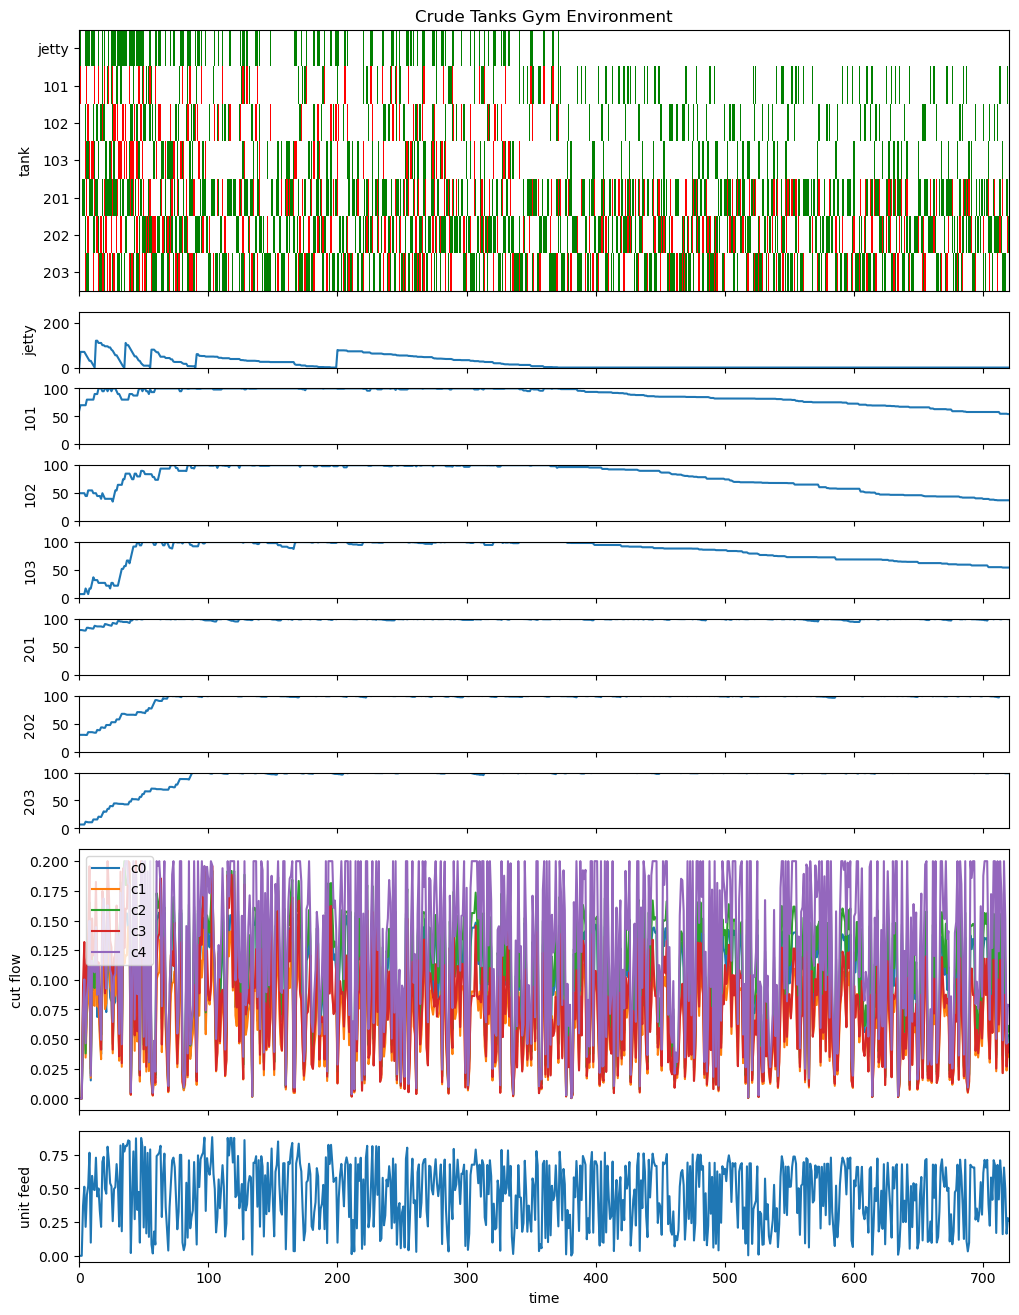

In [451]:
env = crudeTanksEnv()
state0, fixDict = env.reset()
totalReward = 0
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    totalReward += reward 
print(totalReward)
env.render()

In [407]:
fixDict

{'sched': {24: vol: 120.00 comp: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.],
  65: vol:  80.00 comp: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.],
  171: vol:  80.00 comp: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.],
  333: vol: 120.00 comp: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.],
  362: vol:  80.00 comp: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.],
  525: vol: 160.00 comp: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]},
 'assay': array([[0.39162601, 0.21082468, 0.0792312 , 0.09165119, 0.26891313,
         0.16659657, 0.3046913 , 0.10326326, 0.12244524, 0.17877891],
        [0.00411048, 0.26876275, 0.26827578, 0.076347  , 0.21446587,
         0.10471403, 0.04026287, 0.22898371, 0.00834847, 0.23356725],
        [0.09577793, 0.04427852, 0.19243716, 0.12198736, 0.27877858,
         0.3889164 , 0.13452117, 0.1158371 , 0.36756446, 0.20366152],
        [0.15373725, 0.34722212, 0.19250011, 0.24422764, 0.21816657,
         0.00171314, 0.43757539, 0.29869608, 0.23687252, 0.2463501 ],
        [0.35474833, 0.12891193, 0.26755576, 0.46578681, 0.01967586,
         0